In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

first, Iread the file from the john hopins github page (global confirmed case and death case). Although it contains the recovered case, but since I want to analyze Ontario data, the github didn't have complete recovered case for Ontario, so I introduced a new dataset from other resources.

In [8]:
gl_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
gl_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
# gl_recover = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
ca_recovered = pd.read_csv('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_prov/recovered_timeseries_prov.csv')

#  Part 1--Data Cleaning

In [9]:
ca_confirmed = gl_confirmed[gl_confirmed['Country/Region'] == 'Canada'] ## filter the data to get it have only Ontario data left
on_confirmed = ca_confirmed[ca_confirmed['Province/State'] == 'Ontario']
df_confirmed = on_confirmed.transpose().iloc[4:]
df_confirmed.columns = ['confirmed']
df_confirmed['date'] = df_confirmed.index
df_confirmed.reset_index(drop=True, inplace=True)
df_confirmed= df_confirmed[:-7]## result dataset has date and confirmed case, and I drop the data after dec 10th 
df_confirmed.tail(5)

,confirmed,date
319,130962,12/6/20
320,132736,12/7/20
321,134605,12/8/20
322,136599,12/9/20
323,138529,12/10/20


In [10]:
ca_death = gl_death[gl_death['Country/Region'] == 'Canada']## same operation apply on death dataset 
on_death = ca_death[ca_death['Province/State'] == 'Ontario']
df_death = on_death.transpose().iloc[4:]
df_death.columns = ['death']
df_death.reset_index(drop=True, inplace=True)
df_death= df_death[:-7]
df_death.tail(5)

,death
319,3794
320,3816
321,3827
322,3861
323,3891


In [11]:
on_recovered = ca_recovered[ca_recovered['province'] == 'Ontario']
on_recovered.index = np.arange(21, len(on_recovered) + 21)
df_recovered = on_recovered[['date_recovered','cumulative_recovered']]
df_recovered=df_recovered[:-7]
df_recovered.tail(5)

,date_recovered,cumulative_recovered
319,06-12-2020,107990
320,07-12-2020,109402
321,08-12-2020,110951
322,09-12-2020,112875
323,10-12-2020,114679


In [12]:
df = df_confirmed.join(df_recovered).join(df_death)## join the three dataframe toghether for further SIR model building
df = df[['date','confirmed','cumulative_recovered','death']]
df.columns = ['date','confirmed','recovered','death']
df = df.fillna(0)
df['removed'] = df['recovered'] + df['death']## removed population = recovered data + death data (important)
df['infected'] = df['confirmed'] - df['removed']
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y') ## unify the date format
df = df.set_index('date')
df.head()

,confirmed,recovered,death,removed,infected
date,,,,,
2020-01-22,0,0.0,0,0.0,0.0
2020-01-23,0,0.0,0,0.0,0.0
2020-01-24,0,0.0,0,0.0,0.0
2020-01-25,0,0.0,0,0.0,0.0
2020-01-26,1,0.0,0,0.0,1.0


In [13]:
infected = df['infected']
removed = df['removed']
confirmed = df['confirmed']

# Part two Data VIZ and EDA

from the https://globalnews.ca/news/6859636/ontario-coronavirus-timeline/, I get the information about the timeline of covid 19 events in Ontario, on March 17th, Ontario declare the province went into emergency state and start to lockdown, on June 1th, the mask become mandatory requirement in public space, on June 31th, the whole province(most areas) reopens and back to phase 3. I mark the three dates in the graph to show the change on infected, confirmed and recoverd number

In [14]:
emergencystate = '3/17/20'
mask_mandatory = '6/1/20'
phase3reopen = '7/31/20'

In [15]:
confirmed_now = confirmed[-1]

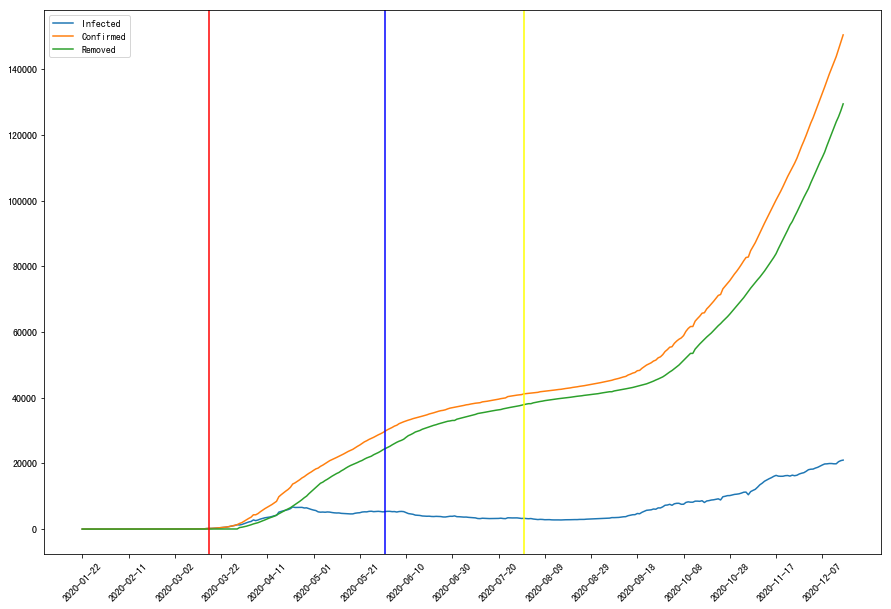

In [350]:
date = df.index.date
fig, ax = plt.subplots(figsize=(15, 10))
x = np.arange(len(date))
plt.plot(x, infected, label='Infected')
plt.plot(x, confirmed, label='Confirmed')
plt.plot(x, removed, label='Removed')
plt.axvline(x=df.index.searchsorted(emergencystate), color="red")
plt.axvline(x=df.index.searchsorted(mask_mandatory), color="blue")
plt.axvline(x=df.index.searchsorted(phase3reopen), color="yellow")
plt.xticks(x[::20], date[::20], rotation=45)
plt.legend()
plt.show()

# Part Three Model Selection & fitting to data

## SIR model 
SIR model is a simple mathematical model of epidemics. An epidemic is when the number of people infected with a disease is increasing in a population. S, I, and R stand for:

S - susceptible. These are people that are not infected with the disease yet. However, they are not immune to it either and so they can become infected with the disease in the future.

I - infected or infectious. These are people that are infected with the disease and can transmit the disease to susceptible people.

R - recovered. These are people who have recovered from the disease and are immune, so they can no longer be infected with the diseas
It works well where people recover from a disease and become immune(Wekpedia,2020). Based on the information provided, this model is proper to analyze the covid 19 disease since people would get immunity once recovered, and we have enough information（death, recovered, infected= confirmed - removed) for building the model. The differential equation for SIR model are shown in the picture below
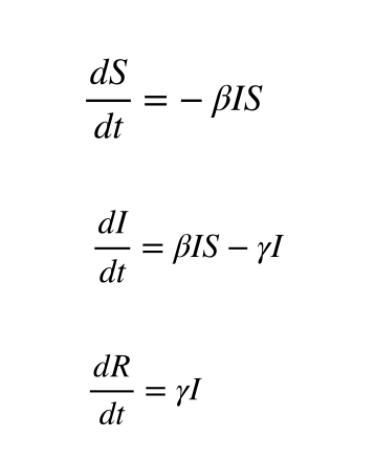

In the equation, β is a parameter controlling how much the disease can be transmitted through exposure. It is determined by the chance of contact and the probability of disease transmission. γ is a parameter expressing how much the disease can be recovered in a specific period. we can estimate the nature of the disease in terms of the power of infection--R0=β/γ. Consequently, R0 > 1 would imply a disease outbreak, while R0 < 1 its disappearance(reference : https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html). We could use R0 to evaluate the covid 19 level of outbreak in different period of time for Ontario.

For case analysis, since the suspected value cannot be determined(due to different contact probbility of people in Ontario), by adjusting the suspected value, we can produce the best, worst and middle case. I get the inspiration from two papers for case analysis(Paper name: Predicting the COVID-19 epidemic in Algeria using the SIR model & Epidemic situation and forecasting of COVID-19 in and outside China).

In [21]:
def loss(point, infected, removed, s_0, i_0, r_0):
    ## define the loss function for the sir model
    size = len(infected)
    beta, gamma = point
    ## define the SIR Differential equation
    def SIR(t, sir):
        S = sir[0]
        I = sir[1]
        R = sir[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = integrate.solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True) ## create the solution for the SIR equation by intergrating 
    l1 = np.sqrt(np.mean((solution.y[1] - infected)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - removed)**2))
    alpha = 0.9
    return alpha * l1 + (1 - alpha) * l2

In [22]:
def predict(new_index, beta, gamma, sir_0): 
    ## the predict function is created to predict the S,I,R once the function get the time period, beta,gamma and initial S0,I0,R0
    s_0, i_0, r_0 = sir_0
    size = len(new_index)
    def SIR(t, sir):
        S = sir[0]
        I = sir[1]
        R = sir[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    return integrate.solve_ivp(SIR, [0, size], sir_0, t_eval=np.arange(0, size, 1))

In [23]:
def train(infected, removed, sir_0):
    s_0, i_0, r_0 = sir_0
    optimal = optimize.minimize(loss, [0.001, 0.001], args=(infected, removed, s_0, i_0, r_0), 
                                method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.5)])
    return optimal

In [24]:
def extended_real(new_index, confirmed, infected, removed):
    size = len(new_index)
    extended_confirmed = np.concatenate((confirmed.values, [None] * (size - len(confirmed.values))))
    extended_infected = np.concatenate((infected.values, [None] * (size - len(infected.values))))
    extended_removed = np.concatenate((removed.values, [None] * (size - len(removed.values))))
    return extended_confirmed, extended_infected, extended_removed

In [25]:
def plot(new_index, optimal, confirmed, infected, removed):
    beta, gamma = optimal.x
    extended_confirmed, extended_infected, extended_removed = extended_real(new_index, confirmed, infected, removed)
    prediction = predict(new_index, beta, gamma, sir_0)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title('Possible COVID19 Ontario Scenario from ' + str(new_index[0]) + ' to ' + str(new_index[-1]))
    plt.plot(new_index, extended_infected, '*', label='Infected')
    plt.plot(new_index, extended_removed, '*', label='Removed')
#     plt.plot(new_index, extended_confirmed, '*', label='Actual Confirmed')
#     plt.plot(new_index, prediction.y[0], label='Predicted Suscepted')
    plt.plot(new_index, prediction.y[1], label='Predicted Infected')
    plt.plot(new_index, prediction.y[2], label='Predicted Removed')
#     plt.plot(new_index, prediction.y[1] + prediction.y[2], label='Predicted Confirmed')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    print(f"beta={beta:.8f}, gamma={gamma:.8f}, R_0(beta/gamma):{(beta/gamma):.8f}")

 For three cases analysis, I chose the peroid from 3/17 when the Ontario announce lockdown to 5/31 when masks become mandatory for training, first I creat a visualization for the actual situation of this peroid

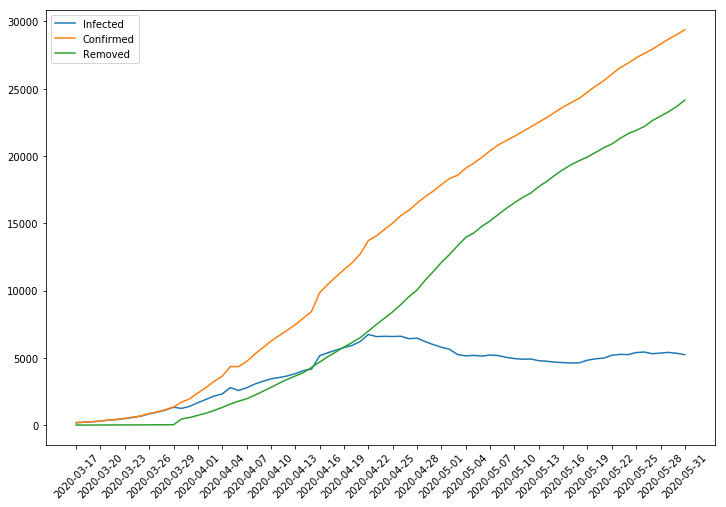

In [26]:
# 3.17 ~ 5.31 after emergencystate before mask_mandatory
df_mid =  df.loc['2020-03-17':'2020-05-31']
infected = df_mid['infected']
removed = df_mid['removed']
confirmed = df_mid['confirmed']
date = df_mid.index.date
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(date))
plt.plot(x, infected, label='Infected')
plt.plot(x, confirmed, label='Confirmed')
plt.plot(x, removed, label='Removed')
plt.xticks(x[::3], date[::3], rotation=45)
plt.legend()
plt.show()

## 3.1 Worst Case

For worst case, all the people(14570000) in Ontario become suspected people(as initial possible infected popuation for the SIR model), which means all people in Ontario would have the probability being infected(no isolation or other measures for covid 19)

In [27]:
population = float(14570000)
s_0 = population # 14570000
i_0 = infected.iloc[0] # 179
r_0 = removed.iloc[0] # 6
sir_0 = [s_0, i_0, r_0]

the * in the plots represents the actual value(training data from 3.17 to 5.31), the green and red lines represents the fitting and predicted infected and removed(recover + death) number of cases. From the graph we know that in this scenario the infected number would reach the peak in early september, and the accumulated death and recover number is increasing expotentially from June to November, in the early december it will reach to five millon, meaning that almost 1/3 of the ontario population would have suffered from covid 19, which is a huge number

beta=0.26334843, gamma=0.21210204, R_0(beta/gamma):1.24161198


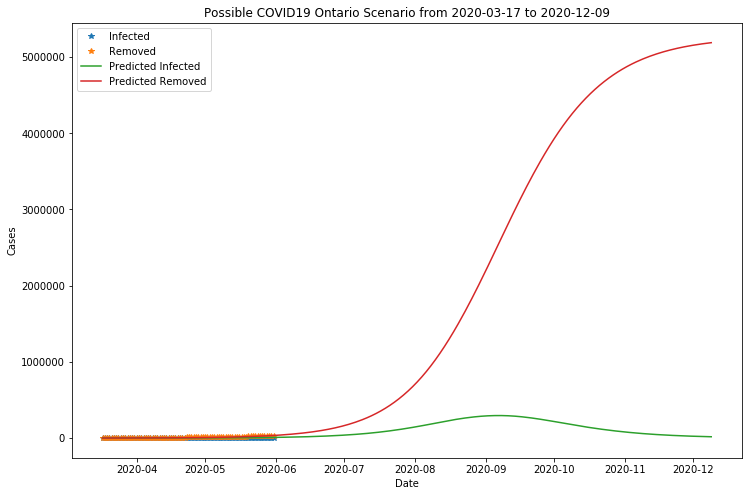

In [28]:
new_index = np.arange('2020-03-17', '2020-12-10', dtype='datetime64[D]')
optimal = train(infected, removed, sir_0)
plot(new_index, optimal, confirmed, infected, removed)

## 3.2 Best Case

For best case,  the infected number of people at the end of the training peroid(5/31) in Ontario become suspected people(set the initial population/suspected size as the confirmed case number). In that case,I assumed all confirmed cases in a relatively independent area come from similar routes of transmission and have been promptly quarantined and treated, and that all close contacts of have also been promptly tested and effectively quarantined.This is the most optimistic estimate, since it also assumes that the epidemic is nearing its end, and there will not be too many new cases, which would bias the overall distribution based on the previously reported cases(Yubei etc., 2020)

In [29]:
s_0 = confirmed[-1] # 29390
i_0 = infected.iloc[0] # 179
r_0 = removed.iloc[0] # 6
sir_0 = [s_0, i_0, r_0]

the * in the plots represents the actual value(training data from 3.17 to 5.31), the green and red lines represents the fitting and predicted infected and removed(recover + death) number of cases. From the graph we know that in this scenario the infected number would decrease since May(about 7000) and almost diappear in July, and the accumulated death and recover number is increasing and become stationary from July for about 25000. In other words, only 25000 people would have been affected by covid 19

beta=0.20603010, gamma=0.08218067, R_0(beta/gamma):2.50703858


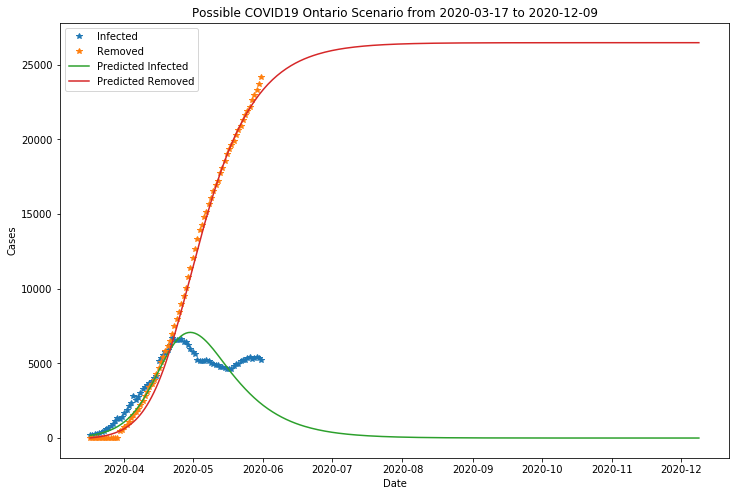

In [30]:
new_index = np.arange('2020-03-17', '2020-12-10', dtype='datetime64[D]')
optimal = train(infected, removed, sir_0)
plot(new_index, optimal, confirmed, infected, removed)

## 3.3 Normal case 

For the middle/normal case, I calculated the percentage of number of infected people recently(december) versus the total population, and get the infect rate is around 0.01(1%), therefore I take the rate and set s0(possible infected population) as the population * infection rate as the normal case. In other word, wI use the actual infected population most recent as the possible infection population in the model. The size of s0 is between the worst case and best case. I got the inspiration for normal case from https://github.com/debadridtt/COVID-19-Analysis/blob/master/Notebooks/SIR%20Modeling%20India.ipynb

In [35]:
s_0 = population * 0.01
i_0 = infected.iloc[0] # 179
r_0 = removed.iloc[0] # 6
sir_0 = [s_0, i_0, r_0]

beta=0.24895752, gamma=0.18127573, R_0(beta/gamma):1.37336376


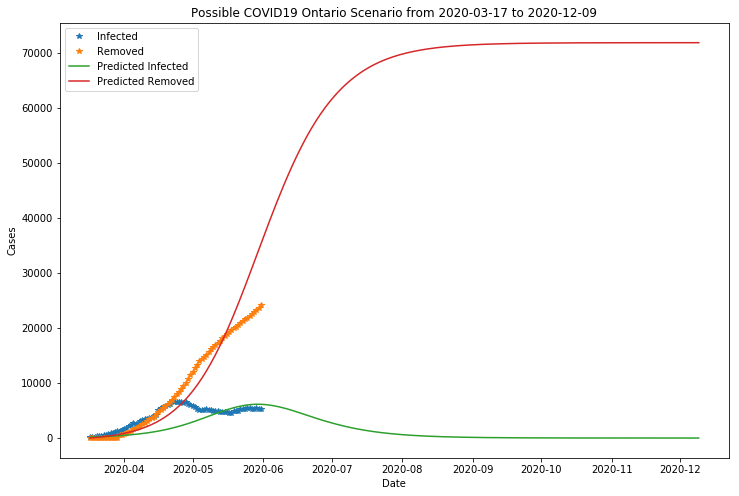

In [36]:
new_index = np.arange('2020-03-17', '2020-12-10', dtype='datetime64[D]')
optimal = train(infected, removed, sir_0)
plot(new_index, optimal, confirmed, infected, removed)

## 3.4 compare

for this part I simply compare my predicted results in the three cases to the actual data with regard to confirmed cases number, in the graph below we can see that the worst case is way much different with atcual situation, and the best canse and middle case fitted better. 

In [37]:
def find_prediction(new_index, sir_0, infected, removed):
    optimal = train(infected, removed, sir_0)
    beta, gamma = optimal.x
    prediction = predict(new_index, beta, gamma, sir_0)
    return prediction

In [38]:
sir_0_worst = [population, infected.iloc[0], removed.iloc[0]]
sir_0_best = [confirmed[-1], infected.iloc[0], removed.iloc[0]]
sir_0_normal = [population * 0.01, infected.iloc[0], removed.iloc[0]]

In [39]:
new_index = np.arange('2020-03-17', '2020-12-10', dtype='datetime64[D]')

In [40]:
prediction_worst = find_prediction(new_index, sir_0_worst, infected, removed)
prediction_best = find_prediction(new_index, sir_0_best, infected, removed)
prediction_normal = find_prediction(new_index, sir_0_normal, infected, removed)

In [41]:
confirmed_prediction_worst = prediction_worst.y[1] + prediction_worst.y[2]
confirmed_prediction_best = prediction_best.y[1] + prediction_best.y[2]
confirmed_prediction_normal = prediction_normal.y[1] + prediction_normal.y[2]

In [42]:
confirmed_actual = df['confirmed'].loc['2020-03-17':'2020-12-09']

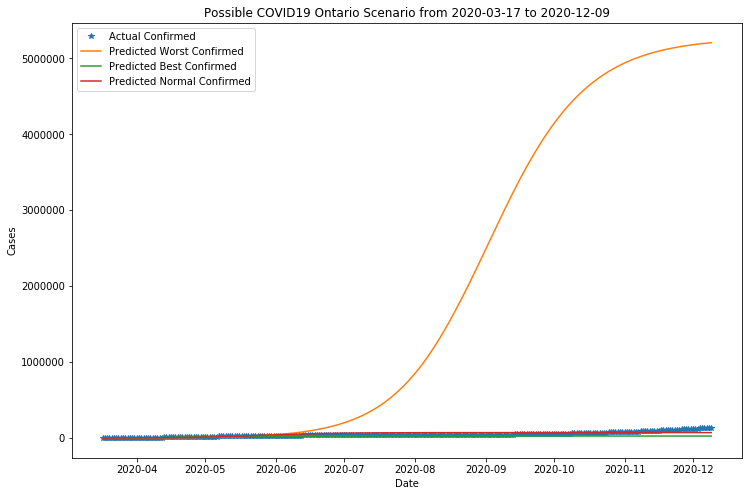

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Possible COVID19 Ontario Scenario from ' + str(new_index[0]) + ' to ' + str(new_index[-1]))
plt.plot(new_index, confirmed_actual, '*', label='Actual Confirmed')
plt.plot(new_index, confirmed_prediction_worst, label='Predicted Worst Confirmed')
plt.plot(new_index, confirmed_prediction_best, label='Predicted Best Confirmed')
plt.plot(new_index, confirmed_prediction_normal, label='Predicted Normal Confirmed')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()


## Part Four 

In this part I first analyze(4.1 to 4.4)- the R0 in three different time zones(stage 1: peroid from lockdown to mask mandatory announcement; stage 2:mask mandatory to phase 3 reopen stage; stage 3: reopen to now 12/10th), use the SIR model to fit the data and calculate and compare the R0 in the 3 stages; Next, I introduce a new dataset which contain the weekly estimates of the total aircraft movements at airports in Canada with NAV CANADA towers to analyze the relationship between number of airlines and infection rate

## 4.1 stage 1

In [431]:
# 3.17 ~ 5.31 after emergencystate before mask_mandatory
df_s1 =  df.loc['2020-03-17':'2020-05-31']
infected = df_s1['infected']
removed = df_s1['removed']
confirmed = df_s1['confirmed']

In [432]:
s_0 = confirmed[-1]
i_0 = infected.iloc[0] # 179
r_0 = removed.iloc[0] # 6
sir_0 = [s_0, i_0, r_0]

beta=0.20603007, gamma=0.08218066, R_0(beta/gamma):2.50703859


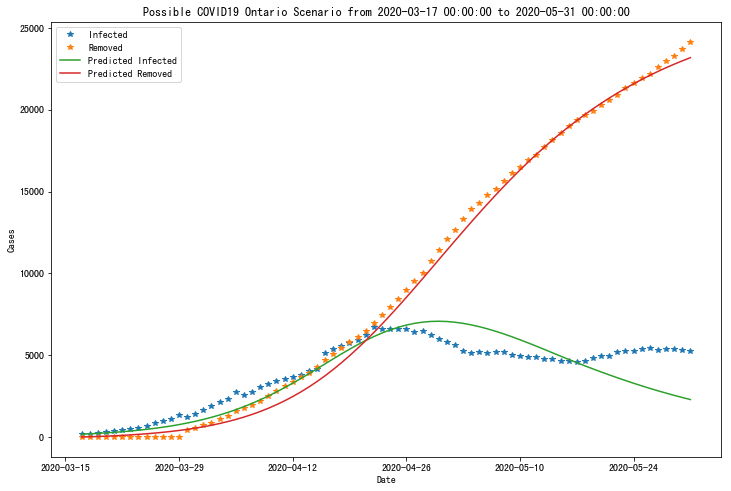

In [433]:
optimal_s1 = train(infected, removed, sir_0)
plot(infected.index, optimal_s1, confirmed, infected, removed)

## 4.2 stage 2

In [434]:
# 6.1 ~ 7.30 after emergencystate before reopen
df_s2 =  df.loc['2020-06-01':'2020-07-30']
infected = df_s2['infected']
removed = df_s2['removed']
confirmed = df_s2['confirmed']

In [435]:
s_0 = confirmed[-1]
i_0 = infected.iloc[0] 
r_0 = removed.iloc[0] 
sir_0 = [s_0, i_0, r_0]

beta=0.05251753, gamma=0.05777689, R_0(beta/gamma):0.90897123


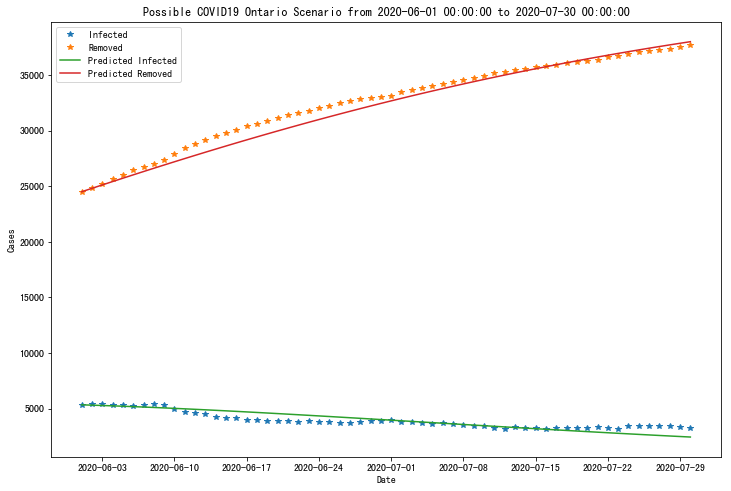

In [436]:
optimal_s2 = train(infected, removed, sir_0)
plot(infected.index, optimal_s2, confirmed, infected, removed)

## 4.3 stage 3

In [437]:
# 7.31 ~ 12.09
df_s3 =  df.loc['2020-07-31':'2020-12-09']
infected = df_s3['infected']
removed = df_s3['removed']
confirmed = df_s3['confirmed']

In [438]:
population = float(14570000)
s_0 = confirmed[-1]
i_0 = infected.iloc[0] 
r_0 = removed.iloc[0] 
sir_0 = [s_0, i_0, r_0]

beta=0.04871293, gamma=0.02967911, R_0(beta/gamma):1.64132065


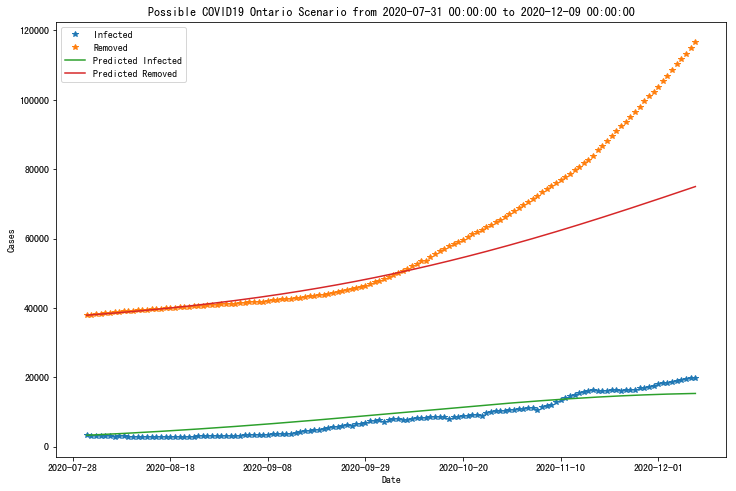

In [439]:
optimal_s3 = train(infected, removed, sir_0)
plot(infected.index, optimal_s3, confirmed, infected, removed)

## 4.4 Compare the R0 for the three stages

From the bar plot and previous calculation, we can see that the R0 for the three stages are 2.5,0.9 and 1.6 respectively. As we mentioned above, R0 stands for the power of infection. Consequently, R0 > 1 would imply a disease outbreak, while R0 < 1 its disappearance. From the first stage, where the covid 19 become severe and Ontario announce the emergency state(lockdown) begins, the infection power is large, which illustrates the high increasing trend for covid 19; In stage 2, when mask becomes mandatory for public space during lock down peroid, the R0 decreases obivously to 0.9, shows the tendency for diminsh; But in stage 3, when all the area in Ontario enter into the phase 3 reopens, the R0 increase and above 1, which illustrates the increasing trend for covid-19 cases.

In [447]:
betas = np.array([optimal_s1.x[0], optimal_s2.x[0], optimal_s3.x[0]])
gammas = np.array([optimal_s1.x[1], optimal_s2.x[1], optimal_s3.x[1]])
R0s = betas / gammas

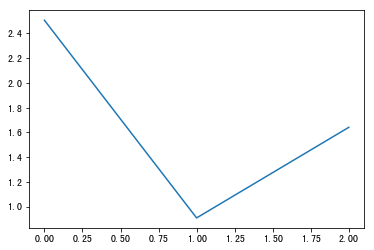

In [449]:
plt.plot(R0s)
plt.show()


## 4.5 flight

For this part, I introduced another dataset from statistics canada about the weekly airlines in Ontario to try to find correlation between the confrimed cases and number of airlines. I build SIR models weekly and get the infection rate beta every week, and then I make a plot to show the trend for beta and airline numbers(normalized to make the two shown on the same plot).Results show the trends of the two variables are coincide. I also conducted a correlation test between these two variables between 2/29 to 11/28 and the coefficient value is 0.6, which suggests potential positive correlation between airline activity and infection rate

In [45]:
aircraft_movements = pd.read_csv('https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=2310028701&latestN=0&startDate=20200201&endDate=20201128&csvLocale=en&selectedMembers=%5B%5B1%5D%2C%5B1%2C2%2C3%5D%5D')
transborder_movements = aircraft_movements[aircraft_movements['COORDINATE'] == 1.2][['REF_DATE','VALUE']]
other_international_movements = aircraft_movements[aircraft_movements['COORDINATE'] == 1.3][['REF_DATE','VALUE']]
transborder_movements.reset_index(drop=True, inplace=True)
other_international_movements.reset_index(drop=True, inplace=True)
international_movements = transborder_movements
international_movements['VALUE'] = transborder_movements['VALUE'] + other_international_movements['VALUE']
international_movements.index = international_movements['REF_DATE']
international_movements = international_movements['VALUE']
international_movements.head(5)

REF_DATE
2020-02-01    11870
2020-02-08    12312
2020-02-15    12565
2020-02-22    12357
2020-02-29    12673
Name: VALUE, dtype: int64

In [338]:
def find_beta(start, end):
    df_month = df.loc[start:end]
    infected = df_month['infected']
    removed = df_month['removed']
    confirmed = df_month['confirmed']
    s_0 = population * 0.01
    i_0 = infected.iloc[0]
    r_0 = removed.iloc[0]
    sir_0 = [s_0, i_0, r_0]
    optimal = train(infected, removed, sir_0)
    return optimal.x[0]

In [339]:
betas = []
for i in range(len(dates)-1):
    betas.append(find_beta(dates[i],dates[i+1]))

In [340]:
betas = betas / max(R0s)
international_movements = international_movements / max(international_movements)

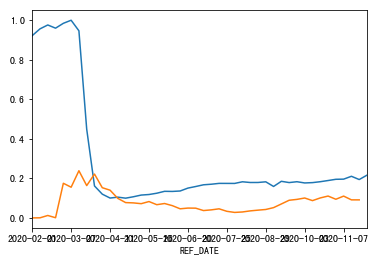

In [342]:
international_movements.plot()
plt.plot(betas)

# Part Five Insights

The three cases analysis illustrates that if no actions are conducted by government, nearly 1/3 of the ontario people would get infected at the end of 2020, which would cause huge negative impact on the whole province. If all confirmed cases have been promptly quarantined and treated, and all close contacts of have also been promptly tested and effectively quarantined at the beginning of the outbreak, the total infected people will only reached 25000 optimally at early July and diminished. The best and worst comparson illustrates the importance of quarantine and isolation. In the three stages of SIR analysis, the first stage is between the lockdown and mask madatory policy for public space, we can see that the power of infection(R0, which is the ratio of infection rate versus recover rate) is 2.6, demonstrating that the infected people would increase gradually in the later peroid. It makes sense because the infected number of people would not decrease right away as lockdown happens, but the lockdown is defitely a wise decision by looking at the second stage R0(0.9, less than 1), when the lockdown with other measures like international traveling limit, mask policy etc. At the three stages when the whole Ontario enters phase three reopen, the R0 incresase to 1.6,also suggests lockdown had a important effect on covid 19 case. It is noticable that I made the mask madatory policy date as one of the stage dividing line, and the R0 before and after this line had obvious difference, it is not very rigorous to say that mask play important role in case control based on my analysis because there are so many factors involved and it is not possible to do control test for mask factor. But based on other study cases and medical suggestions, we know that mask do help to reduce the transmission and infection of covid19. As we all know, the Ontario was locked down again and mask policy had been strengthened.

When weekly flight dataset was introduced, weekly SIR model were built accordingly between 2/29 to 11/28 because before 2/29 there is no infection case. Weekly infection rate beta and number of flights have the coincide trend. Correlation analysis between these two variables(0.6) also shows there is a high correlation. However, as i mentioned above, since too many factors are involved in the covid case, it is not strict to conclude there is a causal relation between the two. But there is a high possibility that reduceing flights help reduce infection rate based on the correlation.According to https://globalnews.ca/news/6859636/ontario-coronavirus-timeline/, the canada us border are closed to non-essential travel since March 18 and had been extended till now, and apparently from the graph we know that the international flights from or to Ontario had been reduced dramatically. It is a wise decision for governemnt to reduce the infection rate. 


Based on the analysis I did, conclusion could be drawn that lockdown, mask for public place and flights reduce all help to improve the covid 19 situation in Ontario. These measures should be supported and continued.
